In [9]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import numpy as np
import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

wildfire = "forestfires.csv"
df = pd.read_csv(wildfire, delimiter=',') 

y = df['area']  # Target variable: diagnosis result
X = df.drop('area', axis=1)

label_encoder = LabelEncoder()
X['month']= label_encoder.fit_transform(X['month'])  # Transform labels to numeric
X['day']= label_encoder.fit_transform(X['day'])  # Transform labels to numeric

X = X.T
X = X[[0]]
f = X.to_numpy()
f.shape


(12, 1)

In [75]:

#images -> feature values
#number of feature values is n -> need n qubits
#for now will generate feature values randomly, using n = 4. 

fmax = X.max()

def theta(i):
    return (np.pi/4)*(f[0,i]/fmax)
#in algorithm 1 part of the paper, this formula is described to calculate angle of rotation for RY gates


In [77]:

def runqc(qc):
    simulator = AerSimulator()

    job = simulator.run(qc, shots=1000)

    result = job.result()

    counts = result.get_counts(qc)
    print(f"Measurement counts: {counts}")

    from qiskit.visualization import plot_histogram
    plot_histogram(counts)

def train(f, fmax):
    def theta(i,j):
        return (np.pi/4)*(f[i,j]/fmax[j])
        #in algorithm 1 part of the paper, this formula is described to calculate angle of rotation for RY gates
    
    m = f.shape[1]
    n = f.shape[0]
    for j in range(m):
        qc = QuantumCircuit(n)
        for i in range(n):
            qc.h(i) #add hadamard gate to all lines
            #qc.h(qubit its on)
            qc.ry(theta(i,j),i) #add ry gate with theta func
            #qc.h(angle, qubit its on)
            if i<n-1:
                qc.cx(i,i+1) #controlled not gate (CNOT) 
                #qc.cx(from, to)
            qc.x(i)
                #qc.x(qubit its on)
            if i<n-1: 
                qc.cry(theta(i,j),i,i+1)
                #qc.cry(angle, from, to)
            qc.x(i)
        runqc(qc)



In [78]:
# Create a new circuit with two qubits
qc = QuantumCircuit(n)

#in qiskit, qubits are automatically initialized to 0
for i in range(n):
    qc.h(i) #add hadamard gate to all lines
    #qc.h(qubit its on)
    qc.ry(theta(i),i) #add ry gate with theta func
    #qc.h(angle, qubit its on)
    if i<n-1:
        qc.cx(i,i+1) #controlled not gate (CNOT) 
        #qc.cx(from, to)
    qc.x(i)
    #qc.x(qubit its on)
    if i<n-1: 
        qc.cry(theta(i),i,i+1)
        #qc.cry(angle, from, to)
    qc.x(i)

output = qc.measure_all()
qc.draw()
#draws the circuit

CircuitError: "Invalid param type <class 'pandas.core.series.Series'> for gate ry."

In [8]:
from qiskit.circuit.library import zz_feature_map
prep = zz_feature_map(2, reps=1)
print(prep.decompose())

from qiskit.circuit.library import efficient_su2
classifier = zz_feature_map(3).compose(efficient_su2(3))
classifier.num_parameters

classifier.parameters  # 'x' for the data preparation, 'θ' for the SU2 parameters

classifier.count_ops()

OrderedDict([('ZZFeatureMap', 1), ('EfficientSU2', 1)])


   ┌────────────┐┌───────────────┐                                         »
0: ┤ U(π/2,0,π) ├┤ U(0,0,2*x[0]) ├──■──────────────────────────────────────»
   ├────────────┤├───────────────┤┌─┴─┐┌──────────────────────────────────┐»
1: ┤ U(π/2,0,π) ├┤ U(0,0,2*x[1]) ├┤ X ├┤ U(0,0,(-π + x[0])*(-π + x[1])*2) ├»
   └────────────┘└───────────────┘└───┘└──────────────────────────────────┘»
«        
«0: ──■──
«   ┌─┴─┐
«1: ┤ X ├
«   └───┘


NameError: name 'OrderedDict' is not defined

Measurement counts: {'1010': 102, '1001': 112, '0111': 90, '1011': 107, '0101': 140, '1111': 16, '0110': 79, '1000': 104, '0010': 32, '0001': 32, '0100': 85, '1100': 15, '0011': 25, '1101': 23, '0000': 19, '1110': 19}


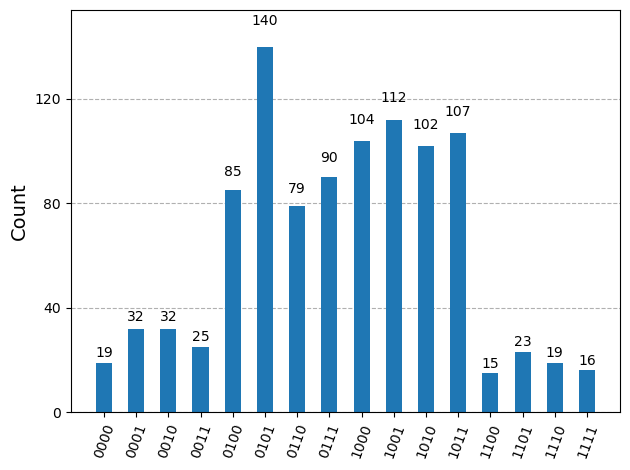

In [8]:
simulator = AerSimulator()

job = simulator.run(qc, shots=1000)

result = job.result()

counts = result.get_counts(qc)
print(f"Measurement counts: {counts}")

from qiskit.visualization import plot_histogram
plot_histogram(counts)

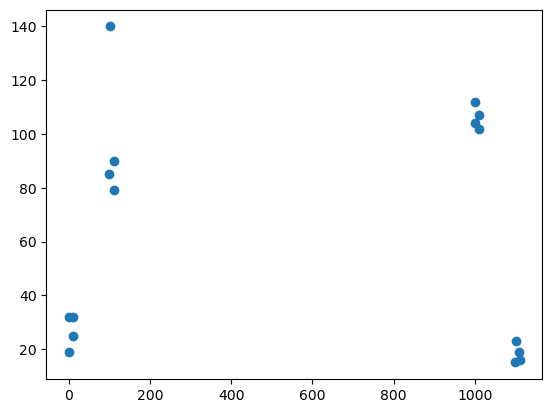

In [30]:
X = list(counts.keys())
Y = list(counts.values())

for i in range(len(X)):
    X[i] = float(X[i])

for i in range(len(Y)):
    Y[i] = float(Y[i])

X = np.array(X)
Y = np.array(Y)

#making the output of the circuit something we can work with? 
import matplotlib.pyplot as plt
plt.scatter(X,Y)

In [35]:
def train(X, Y, model, args):
    #X, Y are datasets, model is from torch.nn,
    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)
    # tensors are multi dimensional matrix of a single data type. this is intialized
    #as a matrix of 32 bit floats. 
    N = len(Y)

    optimizer = optim.SGD(model.parameters(), lr=args.lr)
    # SGD = stochastic gradient descent -> instead of iterating over all the data, uses 1 point or small set to 
    #make computations faster on large datasets. 
    #lr = learning rate

    model.train()
    #turns on training mode for the module
    for epoch in range(args.epoch):
        perm = torch.randperm(N)
        #returns a random permutations of numbers from 0 to N-1
        sum_loss = 0

        for i in range(0, N, args.batchsize):
            #going from 0 to N in steps of the batchsize. 
            x = X[perm[i : i + args.batchsize]].to(args.device) 
                #takes a vector from the tensor and sends it to the device
            y = Y[perm[i : i + args.batchsize]].to(args.device)

            optimizer.zero_grad() #resets the gradients
            output = model(x).squeeze()
            #since the model is a linear transformation, model(x) is a tensor again.
            #this removes all dimensions of size 1 from the tensor
            weight = model.weight.squeeze()
            #model.weight is also a tensor of learnable weights

            loss = torch.mean(torch.clamp(1 - y * output, min=0))
            #calculating the loss
            loss += args.c * (weight.t() @ weight) / 2.0

            loss.backward()
            optimizer.step()

            sum_loss += float(loss)
            #summing the loss over all i

        print("Epoch: {:4d}\tloss: {}".format(epoch, sum_loss / N))


def visualize(X, Y, model):
    W = model.weight.squeeze().detach().cpu().numpy()
    b = model.bias.squeeze().detach().cpu().numpy()

    delta = 0.001
    x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
    y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
    x, y = np.meshgrid(x, y)
    xy = list(map(np.ravel, [x, y]))

    z = (W.dot(xy) + b).reshape(x.shape)
    z[np.where(z > 1.0)] = 4
    z[np.where((z > 0.0) & (z <= 1.0))] = 3
    z[np.where((z > -1.0) & (z <= 0.0))] = 2
    z[np.where(z <= -1.0)] = 1

    plt.figure(figsize=(10, 10))
    plt.xlim([X[:, 0].min() + delta, X[:, 0].max() - delta])
    plt.ylim([X[:, 1].min() + delta, X[:, 1].max() - delta])
    plt.contourf(x, y, z, alpha=0.8, cmap="Greys")
    plt.scatter(x=X[:, 0], y=X[:, 1], c="black", s=10)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    parser = argparse.ArgumentParser() #initialize the args
    parser.add_argument("--c", type=float, default=0.01)
    parser.add_argument("--lr", type=float, default=0.1) #learning rate
    parser.add_argument("--batchsize", type=int, default=5)
    parser.add_argument("--epoch", type=int, default=10)
    parser.add_argument("--device", default="cuda", choices=["cpu", "cuda"])
    args = parser.parse_args([])
    args.device = torch.device(args.device if torch.cuda.is_available() else "cpu")

    print(args)

Namespace(c=0.01, lr=0.1, batchsize=5, epoch=10, device=device(type='cpu'))


5.0